In [1]:
import sys, pickle
print(sys.executable)
import sklearn.preprocessing as pre, scipy, numpy as np, matplotlib.pyplot as plt, glob, os, pyemma
import pandas as pd, seaborn as sns, argparse
from sklearn.feature_selection import mutual_info_regression
from mpl_toolkits.axes_grid1 import make_axes_locatable

#from temp_tf_load import *
sys.path.append('../../hde')
import warnings
warnings.filterwarnings('ignore')
from hde import HDE, analysis

/home/mikejones/scratch-midway2/conda_envs/srv_env/bin/python


Using TensorFlow backend.


In [2]:
# stores msm information 
class seqObj:
    
    def __init__(self, seq, temp, ticks, state_list, nstates, nmodes, minflux=3e-6, reduced=True):
        
        self.ticks = ticks
        self.state_list = state_list
        self.nstates = nstates
        self.nmodes = nmodes
        self.minflux = minflux
        
        #set msm directory:
        if reduced:
            self.meta_dir= f'../implicit/MSM_construction/MSMs/{seq}_dist_reduced_{temp}K_40-250000-55_micro-200_macro-{nstates}_lag-12_srvlag-12/'
        else:
            self.meta_dir= f'../implicit/MSM_construction/MSMs/{seq}_dist_{temp}K_40-250000-190_micro-200_macro-{nstates}_lag-12_srvlag-12/'
            
        # load pre-run from directory
        self.cluster_hde = pickle.load(open(self.meta_dir + 'hde_cluster.pkl', 'rb'))
        self.cluster_tica = pickle.load(open(self.meta_dir + 'tica_cluster.pkl', 'rb'))

        self.msm_hde = pickle.load(open(self.meta_dir + 'msm_hde.pkl', 'rb'))
        self.msm_tica = pickle.load(open(self.meta_dir + 'msm_tica.pkl', 'rb'))

        self.hde_coords = pickle.load(open(self.meta_dir +'hde_coords.pkl', 'rb'))
        self.tica_coords = pickle.load(open(self.meta_dir +'tica_coords.pkl', 'rb'))

        self.dtraj_tica = self.cluster_tica.dtrajs
        self.dtraj_hde = self.cluster_hde.dtrajs
        
        self.nits, self.lags = 8, 30 #50
        self.its_tica = pyemma.msm.its(self.dtraj_tica, lags=self.lags, nits=self.nits)
        self.its_hde = pyemma.msm.its(self.dtraj_hde, lags=self.lags, nits=self.nits, errors='bayes') # turn off bayes for faster run time
        
        # calculate transition matrix
        pcca = self.msm_hde.pcca(self.nstates)
        T = pcca.coarse_grained_transition_matrix.copy()
        T[T < 0] *= 0
        self.T = T/T.sum(axis=1)[:, np.newaxis]
        print(f'finished {seq}')

# collect all sequence objects into a dict
seq_dict = {}
reduced = True

seq_dict['AT-all'] =  seqObj(seq='AT-all', temp=309, reduced = reduced,
                      ticks = ['A', 'T', 'A', 'T', 'A', 'T', 'A', 'T', 'A', 'T'],
                      state_list=['3S4', '5S4', '3S2', '5S2', 'H', 'D'],
                      nstates= 6, nmodes = 5)

seq_dict['GC-end'] =  seqObj(seq='GC-end', temp=317, reduced = reduced,
                      ticks = ['G', 'A', 'T', 'A', 'T', 'A', 'T', 'A', 'T', 'C'],
                      state_list=['5S4', '3S2', '5S2', 'D', 'H'],
                      nstates= 5, nmodes = 5)

seq_dict['GC-core'] = seqObj(seq='GC-core', temp=324, reduced = reduced,
                      ticks = ['A', 'T', 'A', 'T', 'G', 'C', 'A', 'T', 'A', 'T'],
                      state_list=['F4', 'H', 'D'], 
                      nstates= 3, nmodes = 3)

seq_dict['GC-mix'] = seqObj(seq='GC-mix', temp=324, reduced = reduced,
                      ticks = ['A', 'T', 'G', 'A', 'T', 'A', 'T', 'G', 'A', 'T'],
                      state_list=['H', 'D'], 
                      nstates= 2, nmodes = 2)

seq_list = ['AT-all', 'GC-end', 'GC-core', 'GC-mix']
all_states = ['H', '5S2', '3S2', '5S4', '3S4','F4', 'D']
dt, lag = 0.1, 12  # 100 ps per frame x 12 = 1.2 ns

finished AT-all


finished GC-end


finished GC-core


finished GC-mix


AT-all (100000,) (100000, 100) (100000,)
GC-end (100000,) (100000, 100) (100000,)
GC-core (100000,) (100000, 100) (100000,)
GC-mix (100000,) (100000, 100) (100000,)


Text(0.5, 0, "                                Inverse 3' shift (nm$^-1$)")

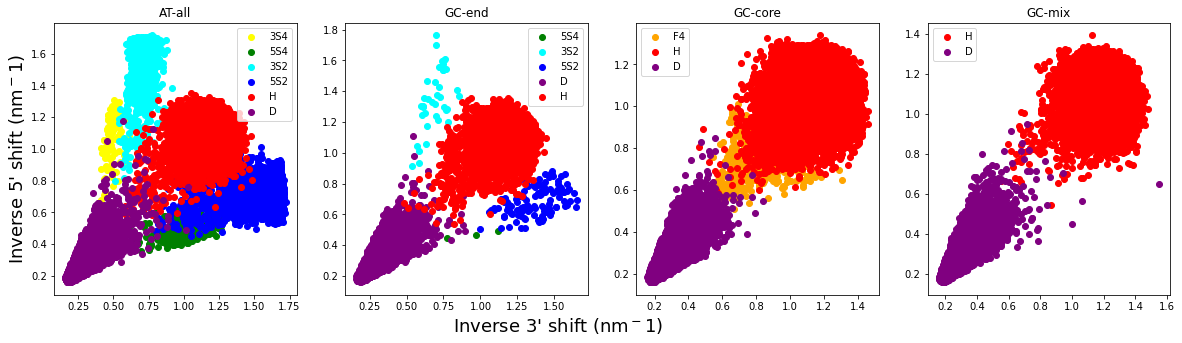

In [3]:
traj_dir = '../implicit/dna_data/' 
suffix = '*_40-250000-190.npy'
stride = 100

# coordintes corresponding to up and down shifts
shift_up = [29+9*i for i in range(8)]
shift_down = [70-9*i for i in range(8)]
color_list = ['red', 'blue', 'cyan', 'green', 'yellow', 'orange', 'purple']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for (seq, seqObj), ax in zip(seq_dict.items(), axes):
    
    # load all intermolecular distances at specified stride
    macros = seqObj.msm_hde.metastable_assignments
    traj_macro = macros[np.concatenate(np.array(seqObj.dtraj_hde)[:, ::stride])]
    traj_path = glob.glob(f'{traj_dir}{seq}{suffix}')[0]
    traj_dist = np.concatenate(np.load(traj_path)[:, ::stride, :100])
    
    # plot on shifted coords
    shift_up_coords = 1/np.mean(traj_dist[:, shift_up], axis=1)
    shift_down_coords = 1/np.mean(traj_dist[:, shift_down], axis=1)
    
    for i, state in enumerate(seqObj.state_list):
        midxs = np.where(traj_macro==i)
        state_idx = all_states.index(state)
        color = color_list[state_idx]
        ax.scatter(shift_up_coords[midxs], shift_down_coords[midxs], c=color, label=state)
        ax.set_title(seq)
    
    ax.legend()
    print(seq, np.shape(traj_macro), np.shape(traj_dist), np.shape(shift_down_coords))
    
#plt.subplots_adjust(hspace=0.3)
axes[0].set_ylabel("Inverse 5' shift (nm$^-1$)", fontsize=18)
axes[1].set_xlabel("                                Inverse 3' shift (nm$^-1$)", fontsize=18)

AT-all (10000000,) (10000000, 100) (10000000,)
GC-end (10000000,) (10000000, 100) (10000000,)
GC-core (10000000,) (10000000, 100) (10000000,)


Text(0.5, 0, '                                                            $d_{3^\\prime}^{-1}$ (nm$^-1$)')

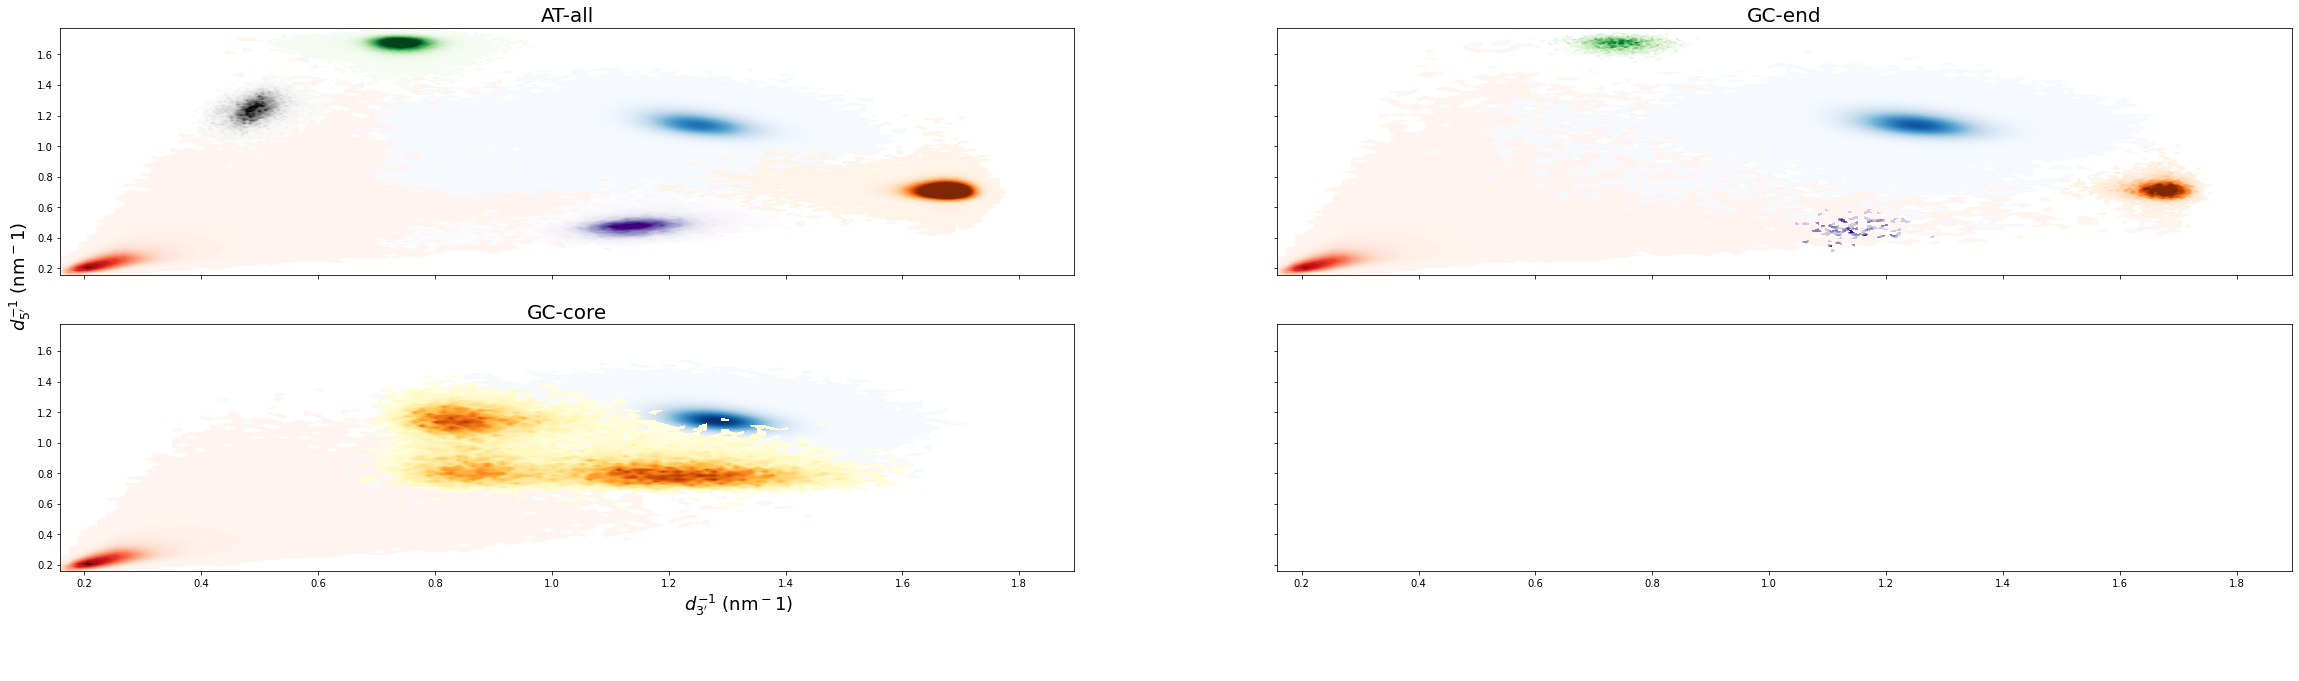

In [44]:
## same as above but plot each states with it's own free energy surface
traj_dir = '../implicit/dna_data/' 
suffix = '*_40-250000-190.npy'
stride = 1

# coordintes corresponding to up and down shifts
shift_up = [29+9*i for i in range(3, 5)]
shift_down = [70-9*i for i in range(3, 5)]
fray_up = [9, 18]
fray_down = [81, 90]
cmap_list = ['Reds', 'Blues', 'Oranges', 'Greens', 'Purples', 'Greys', 'YlOrBr']
state_priority  = ['D', 'H', '5S2', '3S2', '5S4', '3S4', 'F4']
state_vmax = [0.03, 0.01, 0.005, 0.005, 0.006, 0.004, 0.002]
#tate_vmax = [1.0]*7

fig, axes = plt.subplots(2, 2, figsize=(40, 10), sharey=True, sharex=True)


for (seq, seqObj), ax in zip(seq_dict.items(), axes.flatten()):
    
    # turn on GC-mix to make a designated cbar axis
    if seq=='GC-mix': break
    
    # load all intermolecular distances at specified stride
    macros = seqObj.msm_hde.metastable_assignments
    traj_macro = macros[np.concatenate(np.array(seqObj.dtraj_hde)[:, ::stride])]
    traj_path = glob.glob(f'{traj_dir}{seq}{suffix}')[0]
    traj_dist = np.concatenate(np.load(traj_path)[:, ::stride, :100])
    
    # plot on shifted coords
    shift_up_coords = 1/np.mean(traj_dist[:, shift_up], axis=1)
    shift_down_coords = 1/np.mean(traj_dist[:, shift_down], axis=1)
    
    for cmap, state, vmax in zip(cmap_list, state_priority, state_vmax):
        
        if state in seqObj.state_list and not plots_only:
            midxs = np.where(traj_macro==seqObj.state_list.index(state))
            pyemma.plots.plot_density(shift_up_coords[midxs], shift_down_coords[midxs], 
                                      cbar=False, cbar_orientation='vertical', cmap=cmap, ax=ax, nbins=100, vmin=0, vmax=vmax)
            #pyemma.plots.plot_free_energy(shift_up_coords[midxs], shift_down_coords[midxs], cbar=False, cmap=cmap, ax=ax, nbins=100)
            ax.set_title(seq, fontsize=20)
    
    #ax.legend()
    print(seq, np.shape(traj_macro), np.shape(traj_dist), np.shape(shift_down_coords))
    
    
#plt.subplots_adjust(hspace=0.3)
space = ' '*60
axes[1, 0].set_ylabel(space+"$d_{5^\prime}^{-1}$ (nm$^-1$)", fontsize=18)
axes[1, 0].set_xlabel(space+"$d_{3^\prime}^{-1}$ (nm$^-1$)", fontsize=18)
axes[1, 0].set_xlabel(space+"$d_{3^\prime}^{-1}$ (nm$^-1$)", fontsize=18)

Text(0.5, 0, 'Inverse fray down (nm$^-1$)')

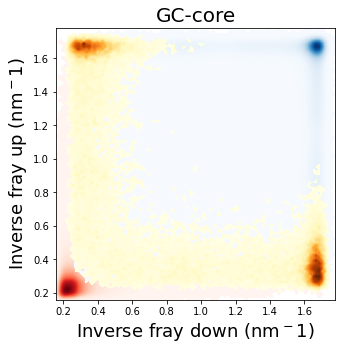

In [34]:
# add a seperate GC-core plot to show fraying distribution

fig, ax = plt.subplots(figsize=(5, 5), sharey=True, sharex=True)
seq = 'GC-core'
seqObj = seq_dict[seq]
    
# load all intermolecular distances at specified stride
macros = seqObj.msm_hde.metastable_assignments
traj_macro = macros[np.concatenate(np.array(seqObj.dtraj_hde)[:, ::stride])]
traj_path = glob.glob(f'{traj_dir}{seq}{suffix}')[0]
traj_dist = np.concatenate(np.load(traj_path)[:, ::stride, :100])

# plot on shifted coords
fray_up_coords = 1/np.mean(traj_dist[:, fray_up], axis=1)
fray_down_coords = 1/np.mean(traj_dist[:, fray_down], axis=1)

for cmap, state in zip(cmap_list, state_priority):
    if state in seqObj.state_list:
        midxs = np.where(traj_macro==seqObj.state_list.index(state))
        pyemma.plots.plot_density(fray_up_coords[midxs], fray_down_coords[midxs], cbar=False, cmap=cmap, ax=ax, nbins=100)
        #pyemma.plots.plot_free_energy(fray_up_coords[midxs], fray_down_coords[midxs], cbar=False, cmap=cmap, ax=ax, nbins=100)
        ax.set_title(seq, fontsize=20)
    
#plt.subplots_adjust(hspace=0.3)
ax.set_ylabel(f"Inverse fray up (nm$^-1$)", fontsize=18)
ax.set_xlabel(f"Inverse fray down (nm$^-1$)", fontsize=18)

(483988,) (483988,) (483988,)
(419708,) (419708,) (419708,)
(76074,) (76074,) (76074,)
(15603,) (15603,) (15603,)
(3450,) (3450,) (3450,)
(1177,) (1177,) (1177,)
(435799,) (435799,) (435799,)
(562474,) (562474,) (562474,)
(1261,) (1261,) (1261,)
(413,) (413,) (413,)
(53,) (53,) (53,)
(528259,) (528259,) (528259,)
(468884,) (468884,) (468884,)
(2857,) (2857,) (2857,)
(544183,) (544183,) (544183,)
(455817,) (455817,) (455817,)


Text(0.5, 0, '                                                            $d_{3^\\prime}^{-1}$ (nm$^-1$)')

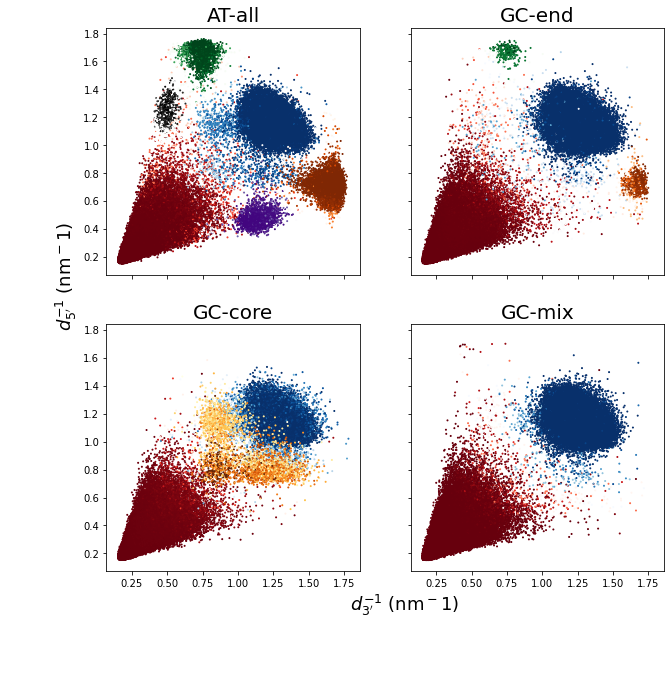

In [45]:
## plot macrostate probability instead of free energy (same color scheme)

## same as above but plot each states with it's own free energy surface
traj_dir = '../implicit/dna_data/' 
suffix = '*_40-250000-190.npy'
stride = 10

# coordintes corresponding to up and down shifts
cmap_list = ['Reds', 'Blues', 'Oranges', 'Greens', 'Purples', 'Greys', 'YlOrBr']
state_priority  = ['D', 'H', '5S2', '3S2', '5S4', '3S4', 'F4']

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)

for (seq, seqObj), ax in zip(seq_dict.items(), axes.flatten()):
    
    # find both macro assignment and probability of assigment
    macros = seqObj.msm_hde.metastable_assignments
    macro_probs = seqObj.msm_hde.metastable_memberships
    
    # translate trajs to macro and probability
    traj_macro =  macros[np.concatenate(np.array(seqObj.dtraj_hde)[:, ::stride])]
    traj_macro_probs =  np.amax(macro_probs[np.concatenate(np.array(seqObj.dtraj_hde)[:, ::stride])], axis=1)

    # load all intermolecular distances at specified stride
    traj_path = glob.glob(f'{traj_dir}{seq}{suffix}')[0]
    traj_dist = np.concatenate(np.load(traj_path)[:, ::stride, :100])
    
    # plot on shifted coords
    shift_up_coords = 1/np.mean(traj_dist[:, shift_up], axis=1)
    shift_down_coords = 1/np.mean(traj_dist[:, shift_down], axis=1)
    
    for cmap, state in zip(cmap_list, state_priority):
        if state in seqObj.state_list:
            midxs = np.where(traj_macro==seqObj.state_list.index(state))
            ax.scatter(shift_up_coords[midxs], shift_down_coords[midxs], c=traj_macro_probs[midxs], cmap=cmap, s=1)
            #ax.hist2d(shift_up_coords[midxs], shift_down_coords[midxs], bins=100, cmap=cmap)
            
            #pyemma.plots.plot_free_energy(shift_up_coords[midxs], shift_down_coords[midxs], cbar=False, cmap=cmap, ax=ax, nbins=100)
            ax.set_title(seq, fontsize=20)
            
            print(np.shape(shift_up_coords[midxs]), np.shape(shift_down_coords[midxs]), np.shape(traj_macro_probs[midxs]))
    
    #ax.legend()
    
#plt.subplots_adjust(hspace=0.3)
space = ' '*60
axes[1, 0].set_ylabel(space+"$d_{5^\prime}^{-1}$ (nm$^-1$)", fontsize=18)
axes[1, 0].set_xlabel(space+"$d_{3^\prime}^{-1}$ (nm$^-1$)", fontsize=18)

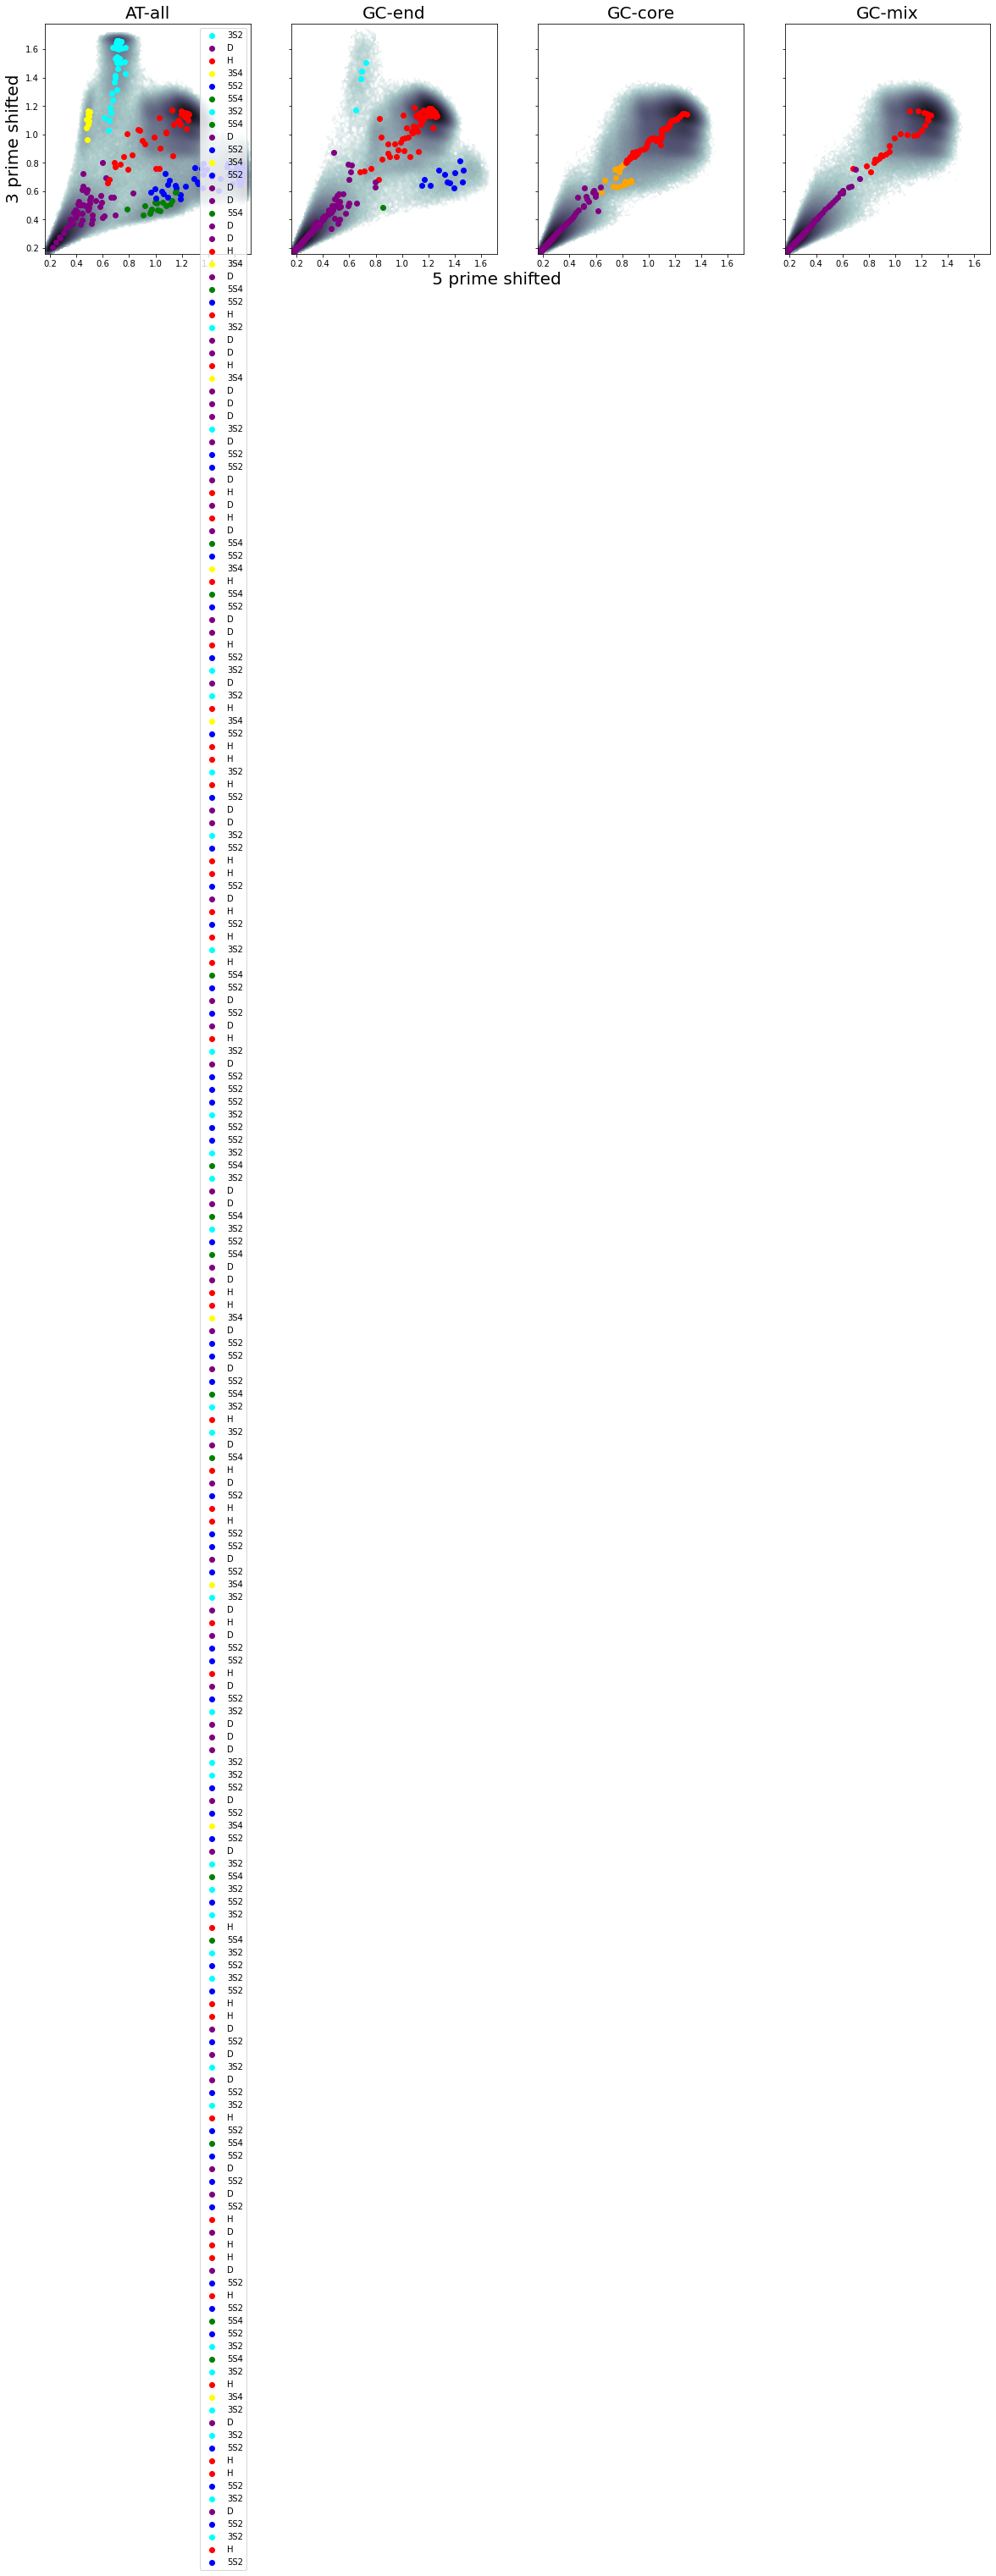

In [6]:
traj_dir = '../implicit/dna_data/' 
suffix = '*_40-250000-190.npy'
stride = 1

# coordintes corresponding to up and down shifts
shift_up = [29+9*i for i in range(8)]
shift_down = [70-9*i for i in range(8)]
color_list = ['red', 'blue', 'cyan', 'green', 'yellow', 'orange', 'purple']

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

for (seq, seqObj), ax in zip(seq_dict.items(), axes):
    
    # load all intermolecular distances at specified stride
    macros = seqObj.msm_hde.metastable_assignments
    traj_micro = np.concatenate(np.array(seqObj.dtraj_hde)[:, ::stride])
    traj_macro = macros[traj_micro]
    traj_path = glob.glob(f'{traj_dir}{seq}{suffix}')[0]
    traj_dist = np.concatenate(np.load(traj_path)[:, ::stride, :100])
    
    # plot on shifted coords
    shift_up_coords = 1/np.mean(traj_dist[:, shift_up], axis=1)
    shift_down_coords = 1/np.mean(traj_dist[:, shift_down], axis=1)
    pyemma.plots.plot_free_energy(shift_up_coords, shift_down_coords, 
                            ax=ax, cbar=False, cmap='bone')
    ax.set_title(seq, fontsize=20)
    
    # plot average of each microstate and color by macrostate
    plotted_states = []
    for i in range(seqObj.msm_hde.nstates):
        midxs = np.where(traj_micro==i)
        shift_up_avg = np.mean(shift_up_coords[midxs])
        shift_down_avg = np.mean(shift_down_coords[midxs])
        state_idx = all_states.index(seqObj.state_list[macros[i]])
        color = color_list[state_idx]
        state = all_states[state_idx]
        if state not in plotted_states: label = state
        else: label = ''
        ax.scatter(shift_up_avg,shift_down_avg,c=color, label=state)
        plotted_states.append(state)

#plt.subplots_adjust(hspace=0.3)
axes[0].set_ylabel('3 prime shifted', fontsize=20)
axes[1].set_xlabel('                                      5 prime shifted', fontsize=20)
axes[0].legend()

(2, 10000000)
H 4 4196816 (2, 4196816)
1.134 ± 0.06 1.251 ± 0.066
5S2 3 760748 (2, 760748)
0.711 ± 0.04 1.665 ± 0.039
3S2 2 155978 (2, 155978)
1.666 ± 0.04 0.742 ± 0.041
5S4 1 34486 (2, 34486)
0.479 ± 0.054 1.14 ± 0.077
3S4 0 11751 (2, 11751)
1.231 ± 0.091 0.493 ± 0.042
D 5 4840221 (2, 4840221)
0.269 ± 0.079 0.269 ± 0.079
(2, 10000000)
H 4 5624923 (2, 5624923)
1.105 ± 0.072 1.252 ± 0.073
5S2 2 12584 (2, 12584)
0.719 ± 0.058 1.664 ± 0.042
3S2 1 4104 (2, 4104)
1.663 ± 0.045 0.745 ± 0.049
5S4 0 540 (2, 540)
0.487 ± 0.105 1.157 ± 0.075
D 3 4357849 (2, 4357849)
0.269 ± 0.081 0.269 ± 0.081
(2, 10000000)
H 1 4688865 (2, 4688865)
1.127 ± 0.06 1.295 ± 0.068
F4 0 28553 (2, 28553)
0.92 ± 0.173 1.042 ± 0.208
D 2 5282582 (2, 5282582)
0.269 ± 0.075 0.269 ± 0.076
(2, 10000000)
H 0 4558264 (2, 4558264)
1.123 ± 0.063 1.25 ± 0.073
D 1 5441736 (2, 5441736)
0.27 ± 0.079 0.269 ± 0.079


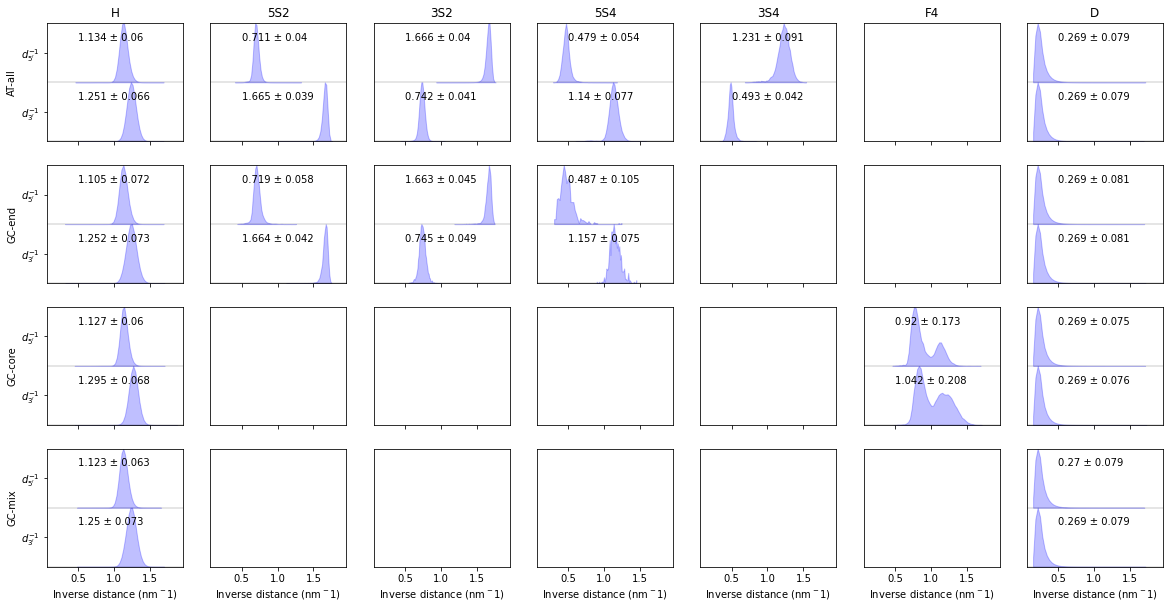

In [26]:
## collection of distance metrics to shows state distrbutions

all_wc = [9*(i+1) for i in range(10)]
in_reg = all_wc[2:8]

fray_up = all_wc[:2]
fray_down = all_wc[-2:]
fray_both = fray_up + fray_down

shift_5S2 = [29+9*i for i in range(3, 5)]
shift_3S2 = [70-9*i for i in range(3, 5)]

shift_5S4 = [49+9*i for i in range(1, 5)]
shift_3S4 = [50-9*i for i in range(1, 5)]

feature_list = [in_reg, fray_up, fray_down, fray_both, shift_3S2, shift_5S2, shift_3S4, shift_5S4]
feature_labels = ['in register', 'frayup', 'fraydown', 'fray', '$d_{5^\prime}^{-1}$', '$d_{3^\prime}^{-1}$', '5S4', '3S4']
#plot_feats = ['in register', 'fray max', 'shift-2 diff', 'shift-4 diff']
plot_feats = ['$d_{5^\prime}^{-1}$', '$d_{3^\prime}^{-1}$']

fig, axes = plt.subplots(len(seq_dict), len(all_states), figsize=(20, 10), sharex=True)

for (seq, seqObj), ax in zip(seq_dict.items(), axes):
    
    # load all intermolecular distances at specified stride
    macros = seqObj.msm_hde.metastable_assignments
    traj_micro = np.concatenate(np.array(seqObj.dtraj_hde)[:, ::stride])
    traj_macro = macros[traj_micro]
    traj_path = glob.glob(f'{traj_dir}{seq}{suffix}')[0]
    traj_dist = np.concatenate(np.load(traj_path)[:, ::stride, :100])
    
    # find the distibution over each feature distance
    feat_dict = {}
    for feat, name in zip(feature_list, feature_labels):
        feat_dict[name] = 1/np.mean(traj_dist[:, feat], axis=1)
    
    # subtract complementary features to reduce dimensionality
    feat_dict['fray max'] = np.minimum(feat_dict['frayup'], feat_dict['fraydown'])
    #feat_dict['shift-2 diff'] = (feat_dict['5S2'] - feat_dict['3S2'])
    #feat_dict['shift-4 diff'] = (feat_dict['5S4'] - feat_dict['3S4'])
    feat_arr = np.array([feat_dict[feat] for feat in plot_feats])
    print(feat_arr.shape)
    
    # calculate features for each macrostate
    for i, state in enumerate(all_states):
        
        if state in seqObj.state_list:
            sidx = seqObj.state_list.index(state)
            midxs = np.where(traj_macro==sidx)[0]
            macro_features = feat_arr[:, midxs]
            print(state, sidx, len(midxs), np.shape(macro_features))
    
            if i == 0: labels = plot_feats 
            else: labels = None
            pyemma.plots.plot_feature_histograms(macro_features.T,ax=ax[i],feature_labels=labels, ylog=False)
            axes[0, i].set_title(state)
            if seq != 'GC-mix': ax[i].set_xlabel('')
                
                
            # calculated and annotate mean and std
            state_means = np.mean(macro_features, axis=1)
            state_stds = np.std(macro_features, axis=1)

            txt5 = str(np.round(state_means[0], 3)) + u" \u00B1 " + str(np.round(state_stds[0], 3))
            txt3 = str(np.round(state_means[1], 3)) + u" \u00B1 " + str(np.round(state_stds[1], 3))
            print(txt5, txt3)

            ax[i].annotate(txt5, (.5, 1.5))
            ax[i].annotate(txt3, (.5, .5))
                
        if i != 0: 
            ax[i].set_ylabel('')
            ax[i].set_yticks([])
                            
        if seq == 'GC-mix': ax[i].set_xlabel('Inverse distance (nm$^-1$)') 
            
    
    ax[0].set_ylabel(seq)
    
                

(2, 1000000)
H 4 419708 (2, 419708)
1.145 ± 0.059 1.25 ± 0.066
5S2 3 76074 (2, 76074)
0.711 ± 0.04 1.666 ± 0.039
3S2 2 15603 (2, 15603)
1.665 ± 0.04 0.742 ± 0.041
5S4 1 3450 (2, 3450)
0.48 ± 0.054 1.141 ± 0.074
3S4 0 1177 (2, 1177)
1.23 ± 0.094 0.494 ± 0.044
D 5 483988 (2, 483988)
0.268 ± 0.079 0.268 ± 0.079
(2, 1000000)
H 4 562474 (2, 562474)
1.144 ± 0.06 1.251 ± 0.073
5S2 2 1261 (2, 1261)
0.718 ± 0.059 1.667 ± 0.038
3S2 1 413 (2, 413)
1.664 ± 0.043 0.745 ± 0.049
5S4 0 53 (2, 53)
0.513 ± 0.137 1.168 ± 0.084
D 3 435799 (2, 435799)
0.269 ± 0.082 0.269 ± 0.081
(2, 1000000)
H 1 468884 (2, 468884)
1.15 ± 0.055 1.281 ± 0.066
F4 0 2857 (2, 2857)
0.917 ± 0.169 1.044 ± 0.207
D 2 528259 (2, 528259)
0.268 ± 0.076 0.268 ± 0.076
(2, 1000000)
H 0 455817 (2, 455817)
1.144 ± 0.06 1.25 ± 0.073
D 1 544183 (2, 544183)
0.268 ± 0.079 0.268 ± 0.079


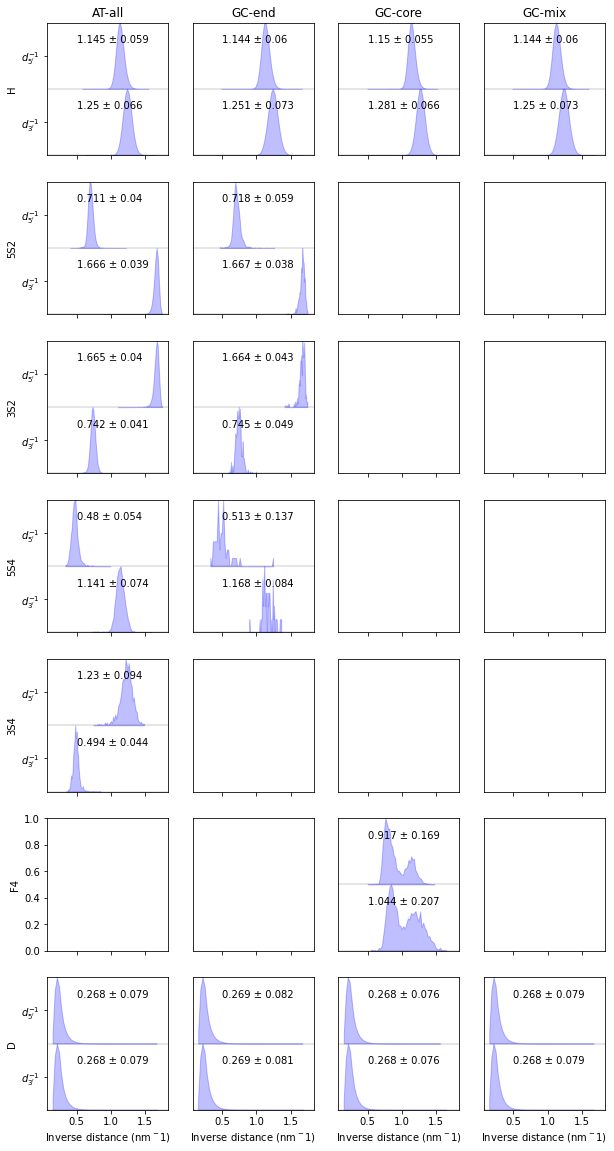

In [52]:
# swith orientation of above

## collection of distance metrics to shows state distrbutions

all_wc = [9*(i+1) for i in range(10)]
in_reg = all_wc[2:8]

fray_up = all_wc[:2]
fray_down = all_wc[-2:]
fray_both = fray_up + fray_down

shift_5S2 = [29+9*i for i in range(3, 5)]
shift_3S2 = [70-9*i for i in range(3, 5)]

shift_5S4 = [49+9*i for i in range(1, 5)]
shift_3S4 = [50-9*i for i in range(1, 5)]

feature_list = [in_reg, fray_up, fray_down, fray_both, shift_3S2, shift_5S2, shift_3S4, shift_5S4]
feature_labels = ['in register', 'frayup', 'fraydown', 'fray', '$d_{5^\prime}^{-1}$', '$d_{3^\prime}^{-1}$', '5S4', '3S4']
#plot_feats = ['in register', 'fray max', 'shift-2 diff', 'shift-4 diff']
plot_feats = ['$d_{5^\prime}^{-1}$', '$d_{3^\prime}^{-1}$']

fig, axes = plt.subplots(len(all_states), len(seq_dict), figsize=(10, 20), sharex=True)

for (seq, seqObj), ax in zip(seq_dict.items(), axes.T):
    
    # load all intermolecular distances at specified stride
    macros = seqObj.msm_hde.metastable_assignments
    traj_micro = np.concatenate(np.array(seqObj.dtraj_hde)[:, ::stride])
    traj_macro = macros[traj_micro]
    traj_path = glob.glob(f'{traj_dir}{seq}{suffix}')[0]
    traj_dist = np.concatenate(np.load(traj_path)[:, ::stride, :100])
    
    # find the distibution over each feature distance
    feat_dict = {}
    for feat, name in zip(feature_list, feature_labels):
        feat_dict[name] = 1/np.mean(traj_dist[:, feat], axis=1)
    
    # subtract complementary features to reduce dimensionality
    feat_dict['fray max'] = np.minimum(feat_dict['frayup'], feat_dict['fraydown'])
    #feat_dict['shift-2 diff'] = (feat_dict['5S2'] - feat_dict['3S2'])
    #feat_dict['shift-4 diff'] = (feat_dict['5S4'] - feat_dict['3S4'])
    feat_arr = np.array([feat_dict[feat] for feat in plot_feats])
    print(feat_arr.shape)
    
    # calculate features for each macrostate
    for i, state in enumerate(all_states):
        
        if state in seqObj.state_list:
            sidx = seqObj.state_list.index(state)
            midxs = np.where(traj_macro==sidx)[0]
            macro_features = feat_arr[:, midxs]
            print(state, sidx, len(midxs), np.shape(macro_features))
    
            if seq == 'AT-all': labels = plot_feats 
            else: labels = None
            pyemma.plots.plot_feature_histograms(macro_features.T,ax=ax[i],feature_labels=labels, ylog=False)
            axes[i, 0].set_ylabel(state)
            if i != 'GC-mix': ax[i].set_xlabel('')
                
            # calculated and annotate mean and std
            state_means = np.mean(macro_features, axis=1)
            state_stds = np.std(macro_features, axis=1)

            txt5 = str(np.round(state_means[0], 3)) + u" \u00B1 " + str(np.round(state_stds[0], 3))
            txt3 = str(np.round(state_means[1], 3)) + u" \u00B1 " + str(np.round(state_stds[1], 3))
            print(txt5, txt3)

            ax[i].annotate(txt5, (.5, 1.5))
            ax[i].annotate(txt3, (.5, .5))
                
        if seq != 'AT-all': 
            ax[i].set_ylabel('')
            ax[i].set_yticks([])
                            
        if i == len(all_states)-1: ax[-1].set_xlabel('Inverse distance (nm$^-1$)') 
            
    
    ax[0].set_title(seq)
    